In [413]:
import warnings # Чтобы не выводились предупреждения

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import requests
import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import os
%matplotlib inline
from datetime import datetime, timedelta


print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')
warnings.filterwarnings("ignore")

Tensorflow version 2.10.0
GPU is ON


## Load Data

In [414]:
df = pd.read_csv('96sku265.csv', sep = ",", parse_dates = ['date'])
df = df.sort_values(by=['date'])
df = df.reset_index().drop('index', axis=1)

In [415]:
def _delete_duplicte (df):
    df_2 = df.copy()
    for i in range(1, len(df)):
        if df.iloc[i].date == df.iloc[i-1].date:
            df_2 = df_2.drop(df_2[df_2.date == df.iloc[i].date].index)
#             n_count = df.iloc[i]['count'] + df.iloc[i-1]['count']
#             new_row = {'date':df.iloc[i].date, 'count':n_count}
#             df_2 = df_2.append(new_row, ignore_index=True)
    return df_2

In [416]:
df = _delete_duplicte(df)
df = df.sort_values(by=['date'])
df = df.reset_index().drop('index', axis=1)
date = df['date']
df = df.set_index('date')
s = pd.Series(df.to_dict()['count'])
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(pd.date_range(list(df.reset_index().date)[0], list(df.reset_index().date)[-1]), fill_value=0)
df = s.to_frame(name='count')

In [433]:
df = df.groupby([lambda x: x.year, lambda x: x.month]).sum()
df

ValueError: No axis named TimeGrouper(key='Date', freq=<Week: weekday=0>, axis=0, sort=True, closed='right', label='right', how='mean', convention='e', origin='start_day') for object type DataFrame

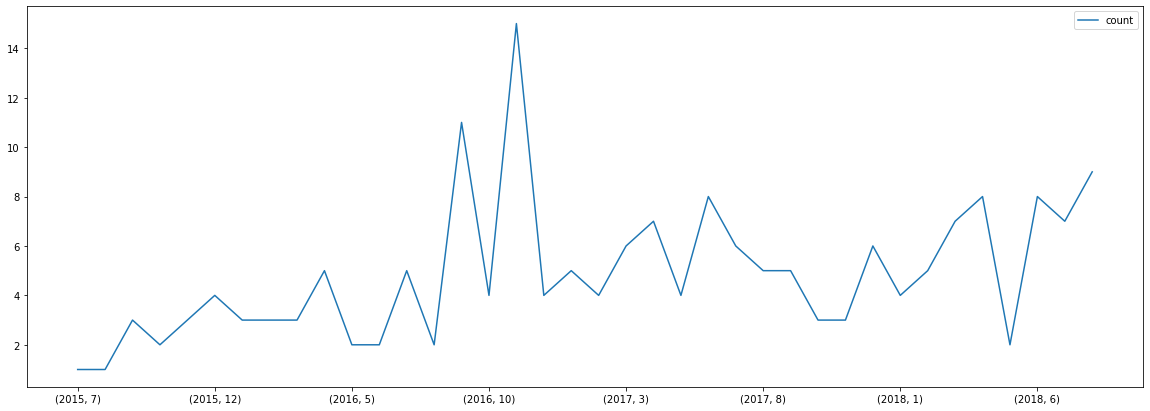

In [418]:
df.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

## Create Test/Train Data 

In [419]:
train = df.iloc[:30]
test = df.iloc[30:]

In [379]:
len(train), len(test)

(30, 8)

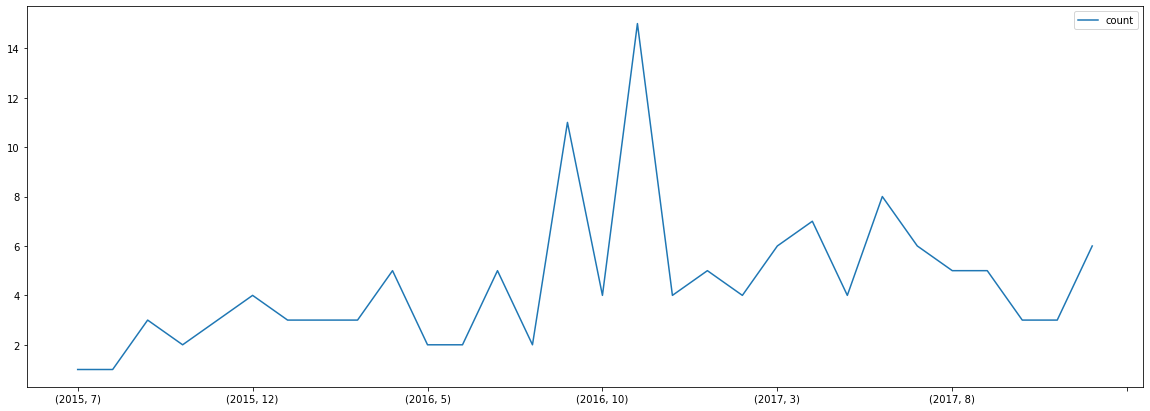

In [380]:
train.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

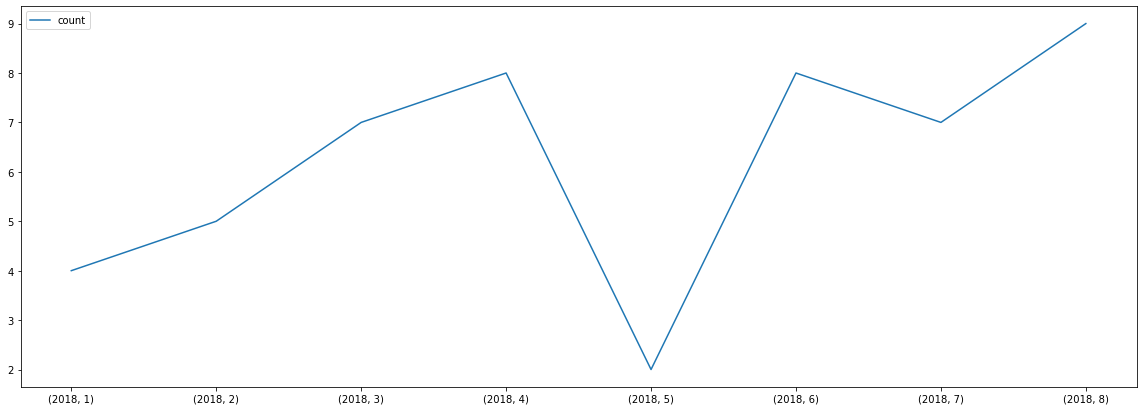

In [381]:
test.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [382]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 3
n_features = 1

generator_train = TimeseriesGenerator(np.array(train), np.array(train), length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(np.array(test), np.array(test), length=n_input, batch_size=1)

X,y = generator_train[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1 1 3]
Predict this y: 
 [[2]]


## Make a Model 

In [383]:
def buying_score(y_true, y_pred):
    return (1+y_pred)/(1+y_true)

In [384]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, ReLU, SimpleRNN
from keras.optimizers import Adam

model = Sequential()
model.add(Input(shape=(n_input, n_features)))

model.add(LSTM(30))
# model.add(SimpleRNN(75, activation = 'relu'))

# model.add(ReLU())
model.add(Dense(n_features))

model.compile(optimizer=Adam(), loss='mse', metrics=['mse', buying_score])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30)                3840      
                                                                 
 dense_9 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [385]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        mse = logs["mse"]
        buying_score = logs["buying_score"]
        if (mse <= self.point):
            self.model.stop_training = True


In [386]:
model.fit(generator_train,epochs=1000) #,callbacks = [StopOnPoint(0.05)])


Epoch 1/1000
27/27 [==============================] - 2s 4ms/step - loss: 26.0856 - mse: 26.0856 - buying_score: 0.2968
Epoch 2/1000
27/27 [==============================] - 0s 5ms/step - loss: 19.5099 - mse: 19.5099 - buying_score: 0.4683
Epoch 3/1000
27/27 [==============================] - 0s 5ms/step - loss: 13.4158 - mse: 13.4158 - buying_score: 0.6665
Epoch 4/1000
27/27 [==============================] - 0s 5ms/step - loss: 9.5519 - mse: 9.5519 - buying_score: 0.8746
Epoch 5/1000
27/27 [==============================] - 0s 4ms/step - loss: 7.9487 - mse: 7.9487 - buying_score: 1.0140
Epoch 6/1000
27/27 [==============================] - 0s 5ms/step - loss: 7.6451 - mse: 7.6451 - buying_score: 1.0858
Epoch 7/1000
27/27 [==============================] - 0s 5ms/step - loss: 7.5611 - mse: 7.5611 - buying_score: 1.1290
Epoch 8/1000
27/27 [==============================] - 0s 4ms/step - loss: 7.5238 - mse: 7.5238 - buying_score: 1.1366
Epoch 9/1000
27/27 [==============================

27/27 [==============================] - 0s 4ms/step - loss: 4.1849 - mse: 4.1849 - buying_score: 1.0950
Epoch 138/1000
27/27 [==============================] - 0s 4ms/step - loss: 4.1904 - mse: 4.1904 - buying_score: 1.1058
Epoch 139/1000
27/27 [==============================] - 0s 4ms/step - loss: 4.2051 - mse: 4.2051 - buying_score: 1.0730
Epoch 140/1000
27/27 [==============================] - 0s 4ms/step - loss: 4.2463 - mse: 4.2463 - buying_score: 1.0776
Epoch 141/1000
27/27 [==============================] - 0s 4ms/step - loss: 4.1637 - mse: 4.1637 - buying_score: 1.0882
Epoch 142/1000
27/27 [==============================] - 0s 4ms/step - loss: 4.3041 - mse: 4.3041 - buying_score: 1.1288
Epoch 143/1000
27/27 [==============================] - 0s 4ms/step - loss: 4.1622 - mse: 4.1622 - buying_score: 1.0667
Epoch 144/1000
27/27 [==============================] - 0s 4ms/step - loss: 4.2245 - mse: 4.2245 - buying_score: 1.0942
Epoch 145/1000
27/27 [==============================] -

27/27 [==============================] - 0s 4ms/step - loss: 1.4406 - mse: 1.4406 - buying_score: 1.0350
Epoch 274/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.4919 - mse: 1.4919 - buying_score: 1.0561
Epoch 275/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.4822 - mse: 1.4822 - buying_score: 1.0178
Epoch 276/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.4505 - mse: 1.4505 - buying_score: 1.0520
Epoch 277/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.4343 - mse: 1.4343 - buying_score: 1.0576
Epoch 278/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.4350 - mse: 1.4350 - buying_score: 1.0307
Epoch 279/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.4059 - mse: 1.4059 - buying_score: 1.0453
Epoch 280/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.4136 - mse: 1.4136 - buying_score: 1.0474
Epoch 281/1000
27/27 [==============================] -

27/27 [==============================] - 0s 4ms/step - loss: 1.1801 - mse: 1.1801 - buying_score: 1.0366
Epoch 410/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.1867 - mse: 1.1867 - buying_score: 1.0265
Epoch 411/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.2284 - mse: 1.2284 - buying_score: 1.0411
Epoch 412/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.1856 - mse: 1.1856 - buying_score: 1.0528
Epoch 413/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.1810 - mse: 1.1810 - buying_score: 1.0377
Epoch 414/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.1565 - mse: 1.1565 - buying_score: 1.0407
Epoch 415/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.1699 - mse: 1.1699 - buying_score: 1.0374
Epoch 416/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.2019 - mse: 1.2019 - buying_score: 1.0284
Epoch 417/1000
27/27 [==============================] -

27/27 [==============================] - 0s 4ms/step - loss: 0.9437 - mse: 0.9437 - buying_score: 1.0268
Epoch 546/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.9799 - mse: 0.9799 - buying_score: 1.0236
Epoch 547/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.9710 - mse: 0.9710 - buying_score: 1.0345
Epoch 548/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.0232 - mse: 1.0232 - buying_score: 1.0517
Epoch 549/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.9087 - mse: 0.9087 - buying_score: 1.0294
Epoch 550/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.9337 - mse: 0.9337 - buying_score: 1.0304
Epoch 551/1000
27/27 [==============================] - 0s 4ms/step - loss: 1.0092 - mse: 1.0092 - buying_score: 1.0476
Epoch 552/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.9458 - mse: 0.9458 - buying_score: 1.0320
Epoch 553/1000
27/27 [==============================] -

27/27 [==============================] - 0s 4ms/step - loss: 0.7344 - mse: 0.7344 - buying_score: 1.0184
Epoch 682/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.8240 - mse: 0.8240 - buying_score: 1.0170
Epoch 683/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.7470 - mse: 0.7470 - buying_score: 1.0312
Epoch 684/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.7478 - mse: 0.7478 - buying_score: 1.0200
Epoch 685/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.8328 - mse: 0.8328 - buying_score: 1.0256
Epoch 686/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.8990 - mse: 0.8990 - buying_score: 1.0598
Epoch 687/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.8060 - mse: 0.8060 - buying_score: 0.9995
Epoch 688/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.8318 - mse: 0.8318 - buying_score: 1.0298
Epoch 689/1000
27/27 [==============================] -

27/27 [==============================] - 0s 4ms/step - loss: 0.6512 - mse: 0.6512 - buying_score: 1.0282
Epoch 818/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.5664 - mse: 0.5664 - buying_score: 1.0204
Epoch 819/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.5971 - mse: 0.5971 - buying_score: 1.0186
Epoch 820/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.5856 - mse: 0.5856 - buying_score: 1.0329
Epoch 821/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.5999 - mse: 0.5999 - buying_score: 1.0140
Epoch 822/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.5784 - mse: 0.5784 - buying_score: 1.0187
Epoch 823/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.5388 - mse: 0.5388 - buying_score: 1.0171
Epoch 824/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.5781 - mse: 0.5781 - buying_score: 1.0294
Epoch 825/1000
27/27 [==============================] -

27/27 [==============================] - 0s 4ms/step - loss: 0.3437 - mse: 0.3437 - buying_score: 1.0080
Epoch 954/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.3581 - mse: 0.3581 - buying_score: 1.0065
Epoch 955/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.3488 - mse: 0.3488 - buying_score: 1.0309
Epoch 956/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.3430 - mse: 0.3430 - buying_score: 1.0118
Epoch 957/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.3278 - mse: 0.3278 - buying_score: 1.0155
Epoch 958/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.3345 - mse: 0.3345 - buying_score: 1.0109
Epoch 959/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.3337 - mse: 0.3337 - buying_score: 1.0006
Epoch 960/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.2759 - mse: 0.2759 - buying_score: 1.0038
Epoch 961/1000
27/27 [==============================] -

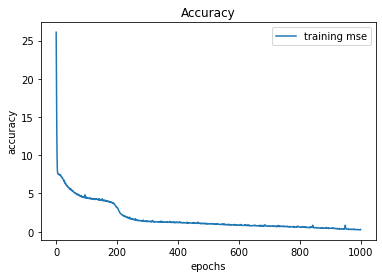

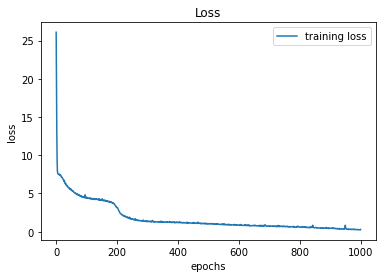

In [387]:
plt.figure(0)
plt.plot(model.history.history['mse'], label='training mse')
# plt.plot(model.history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(model.history.history['loss'], label='training loss')
# plt.plot(model.history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [388]:
# model.save('bestBIG.h5')

# Test Model

## Test data

In [389]:
test_predictions = []
first_eval_batch = np.array(test)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(n_input):
    test_predictions.append(np.array(test)[i]) 
    
try:
    for i in range(len(test)-3):
        current_pred = model.predict(current_batch)
        current_pred = round(current_pred[0][0])
        print(current_pred)
        if current_pred < 0: current_pred = current_pred*(-1)
        test_predictions.append([current_pred])#[np.argmax(current_pred)]) 
        current_batch = np.append(current_batch[:,1:,:],[[np.array(test)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 322ms/step
4
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 17ms/step
5
1/1 [==============================] - 0s 16ms/step
6
1/1 [==============================] - 0s 16ms/step
14


In [390]:
test_copy = test.copy()
test_copy['Predictions'] = np.array(test_predictions)
test_copy

count  Predictions
2018 1      4            4
     2      5            5
     3      7            7
     4      8            4
     5      2            5
     6      8            5
     7      7            6
     8      9           14

<AxesSubplot:>

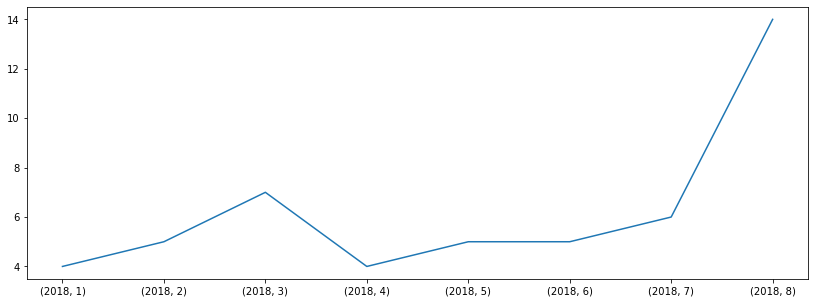

In [391]:
test_copy['Predictions'].plot(figsize=(14,5))


<AxesSubplot:>

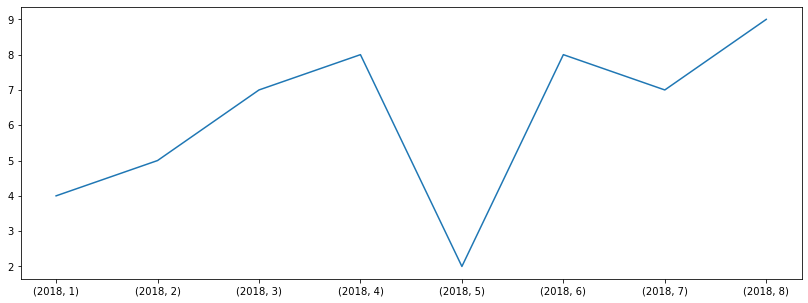

In [392]:
test_copy['count'].plot(figsize=(14,5))


<AxesSubplot:>

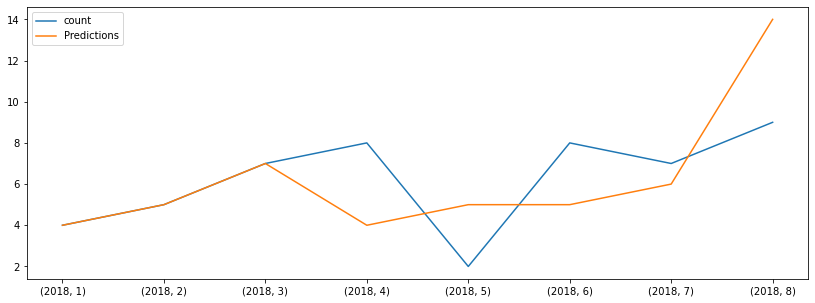

In [393]:
test_copy.plot(figsize=(14,5))


In [394]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy['count']),list(test_copy['Predictions'])):
#     if y_true != y_pred:
#         print(y_true, y_pred, buying_score(y_true, y_pred))
    metric_list.append(buying_score(y_true, y_pred))

In [395]:
mean(metric_list)

1.0746527777777777

In [396]:
Bought = sum(list(test_copy['Predictions']))
Sold = sum(list(test_copy['count']))
Bought, Sold

(50, 50)

In [397]:
print('Перезакуп {}'.format (Bought - Sold)) if Bought/Sold > 1 else print('Недозакуп {}'.format (Bought - Sold))

Недозакуп 0


In [398]:
Bought/Sold

1.0

## Check second SKU

In [399]:
df_2 = pd.read_csv('42sku13653.csv', sep = ",", parse_dates = ['date'])

In [400]:
df_2 = _delete_duplicte(df_2)
df_2 = df_2.sort_values(by=['date'])
df_2 = df_2.reset_index().drop('index', axis=1)
date = df_2['date']
df_2 =df_2.set_index('date')
s = pd.Series(df_2.to_dict()['count'])
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(pd.date_range(list(df_2.reset_index().date)[0], list(df_2.reset_index().date)[-1]), fill_value=0)
df_2 = s.to_frame(name='count')

In [401]:
df_2

,count
2017-04-04,1
2017-04-05,0
2017-04-06,0
2017-04-07,0
2017-04-08,0
...,...
2018-07-14,0
2018-07-15,0
2018-07-16,0
2018-07-17,1


In [402]:
df_2 = df_2.groupby([lambda x: x.year, lambda x: x.month]).sum()
df_2

count
2017 4       2
     5       0
     6       1
     7       1
     8       0
     9       0
     10      0
     11      2
     12      2
2018 1       2
     2       0
     3       1
     4       2
     5       0
     6       0
     7       2

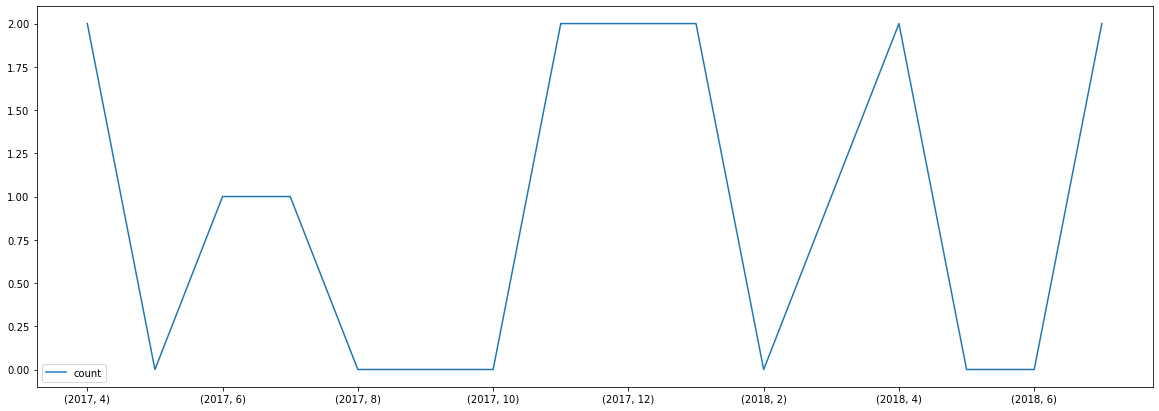

In [403]:
df_2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [404]:
df2_predictions = []
first_eval_batch = np.array(df_2)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(n_input):
    df2_predictions.append(np.array(df_2)[i][0]) 
    
try:
    for i in range(len(np.array(df_2))-3):
        current_pred = model.predict(current_batch)
        current_pred = round(current_pred[0][0])
        if current_pred < 0: current_pred = current_pred*(-1)
        print(current_pred)
        df2_predictions.append(current_pred)#[np.argmax(current_pred)]) 
        current_batch = np.append(current_batch[:,1:,:],[[np.array(df_2)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 16ms/step
3
1/1 [==============================] - 0s 17ms/step
3
1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 28ms/step
3
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
2


In [405]:
test_copy_DF2 = df_2.copy()
test_copy_DF2['Predictions'] = np.array(df2_predictions)
test_copy_DF2

count  Predictions
2017 4       2            2
     5       0            0
     6       1            1
     7       1            2
     8       0            2
     9       0            1
     10      0            1
     11      2            1
     12      2            2
2018 1       2            3
     2       0            3
     3       1            2
     4       2            2
     5       0            3
     6       0            1
     7       2            2

In [406]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(test_copy_DF2['count'],test_copy_DF2['Predictions'])

0.4417436844001529

In [407]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy_DF2['count']),list(test_copy_DF2['Predictions'])):
    metric_list.append(buying_score(y_true, y_pred))
    
mean(metric_list)    

1.75

In [408]:
s = sum(list(test_copy_DF2['count']))
b = sum(list(test_copy_DF2['Predictions']))
b-s

13

In [409]:
b/s

1.8666666666666667

<AxesSubplot:>

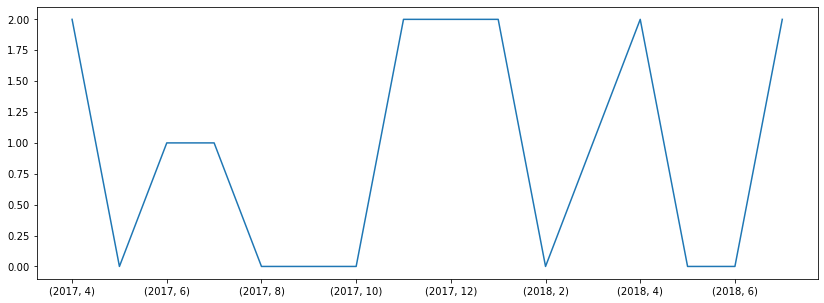

In [410]:
test_copy_DF2['count'].plot(figsize=(14,5))


<AxesSubplot:>

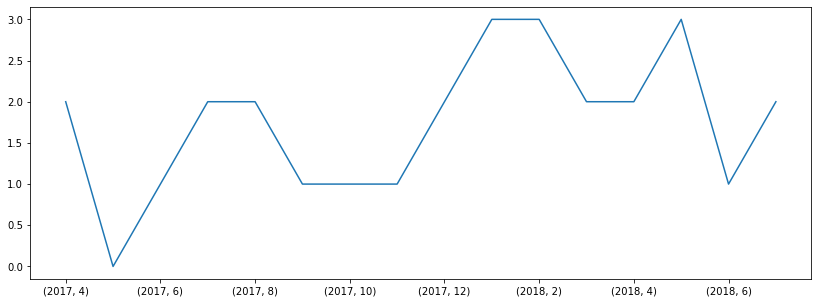

In [411]:
test_copy_DF2['Predictions'].plot(figsize=(14,5))


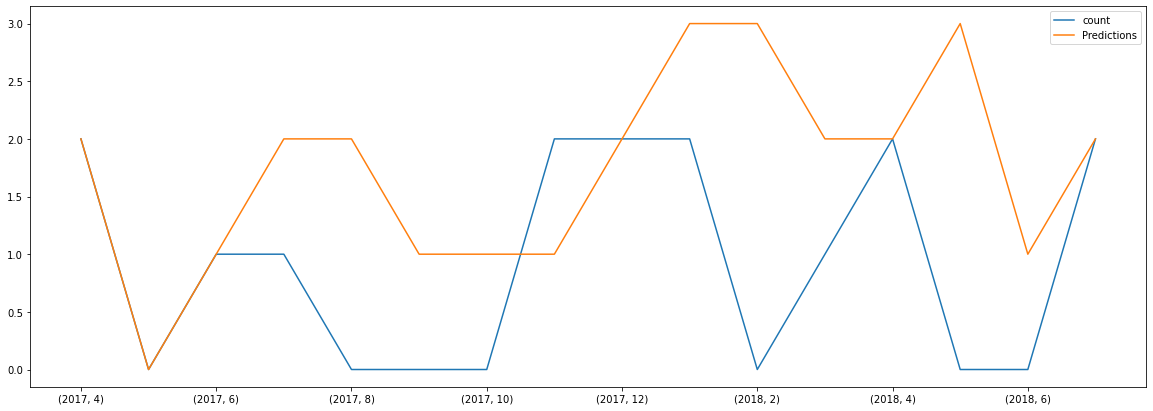

In [412]:
test_copy_DF2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

## Predict New Month

In [137]:
new_predictions = []
first_eval_batch =  np.array(test)[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
    for i in range(40):
        current_pred = model.predict(current_batch)[0]
        new_predictions.append(round(current_pred[0])) 
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
except:
    pass

1/1 [==============================] - 0s 16ms/step


In [138]:
test_copy_3 = test.copy()
test_copy_3

count
2015 7       1
     8       1
     9       3
     10      2
     11      3
     12      4
2016 1       3
     2       3
     3       3
     4       5
     5       2
     6       2
     7       5
     8       2
     9      11
     10      4
     11     15
     12      4
2017 1       5
     2       4

In [139]:
test_copy_3.index.name='date'


In [140]:
import datetime
new_data_list = []
for i in range(1, 41):
    new_data_list.append(list(test_copy_3.reset_index().date)[-1]+ datetime.timedelta(days=i))

AttributeError: 'DataFrame' object has no attribute 'date'

In [ ]:
predicted_df=pd.DataFrame({'date':new_data_list})
predicted_df['count'] = new_predictions
predicted_df = predicted_df.set_index('date')

In [ ]:
plt.figure(figsize = (20, 7))
plt.plot(df)
plt.plot(predicted_df)
plt.show()

In [ ]:
plt.figure(figsize = (20, 7))
plt.plot(test_copy_3)
plt.plot(predicted_df)
plt.show()

## Predict New Month for second SKU

In [227]:
new_predictions_2 = []
first_eval_batch =  np.array(df_2)[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
    for i in range(40):
        current_pred = model.predict(current_batch)
        current_pred = round(current_pred[0][0])
        if current_pred < 0: current_pred = current_pred*(-1)
        print(current_pred)
        new_predictions_2.append(current_pred) 
        current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 15ms/step
1
1/1 [==============================] - 0s 18ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [=======================

In [228]:
test_copy_DF2.index.name='date'
test_copy_DF2

count  Predictions
2017 4       2            2
     5       0            0
     6       1            1
     7       1            1
     8       0            0
     9       0            0
     10      0            0
     11      2            0
     12      2            1
2018 1       2            1
     2       0            2
     3       1            2
     4       2            1
     5       0            0
     6       0            1
     7       2            1

In [144]:
import datetime
new_data_list = []
for i in range(1, 41):
    new_data_list.append(list(test_copy_DF2.reset_index().date)[-1]+ datetime.timedelta(days=i))

AttributeError: 'DataFrame' object has no attribute 'date'

In [ ]:
predicted_df=pd.DataFrame({'date':new_data_list})
predicted_df['count'] = new_predictions_2
predicted_df = predicted_df.set_index('date')

In [ ]:
plt.figure(figsize = (20, 7))
plt.plot(df_2)
plt.plot(predicted_df)
plt.show()